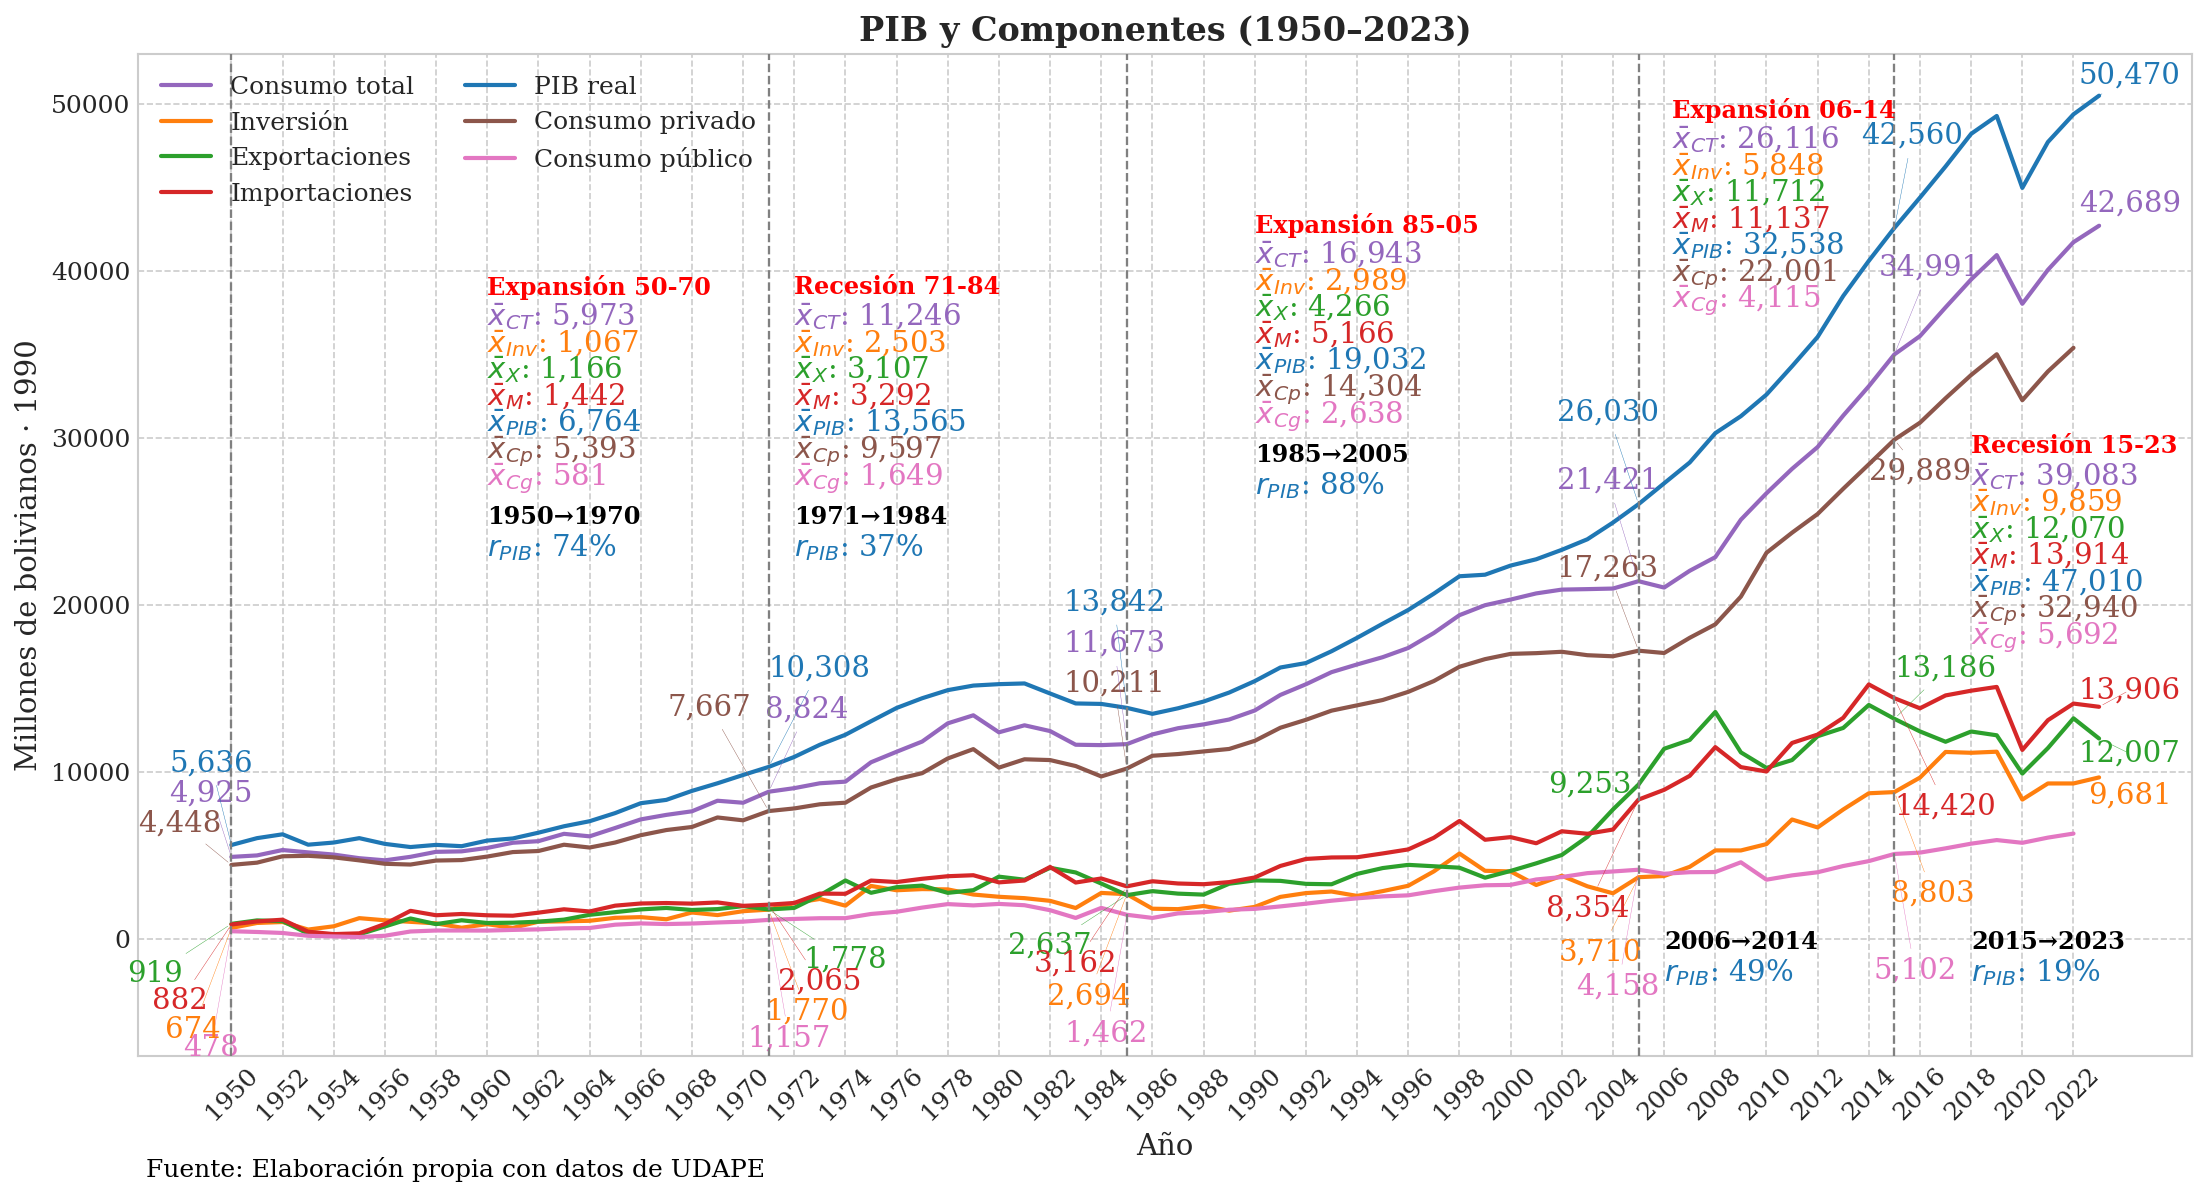

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3, os
import sys
sys.path.append(os.path.abspath('../'))          # utilidades propias
from graficos_utils import (
    add_hitos, add_cycle_means_multi,
    add_year_value_annotations, add_period_growth_annotations_multi,
    add_participation_cycle_boxes
)

EXPANSION_50_70   = slice(1950, 1970)   # Expansión
RECESION_71_84    = slice(1971, 1984)   # Recesión
EXPANSION_85_05   = slice(1985, 2005)   # Expansión
ACUMULACION_06_14 = slice(2005, 2014)   # Acumulación (expansión)
RECESION_15_23    = slice(2015, 2023)   # Recesión

# ── 1. Configuración general y salida ────────────────────────────────
output_dir = "../../../../assets/tesis/serie_completa/pib"
os.makedirs(output_dir, exist_ok=True)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family':'serif','font.size':12,
    'axes.titlesize':16,'axes.labelsize':14,
    'grid.linestyle':'--','lines.linewidth':2,
    'figure.dpi':150,'savefig.bbox':'tight'
})
component_colors = {
    'pib_real_base_1990': '#1f77b4'
}
# ── 2. Carga de datos ────────────────────────────────────────────────
with sqlite3.connect('../../../../db/proyectomacro.db') as conn:
    df = pd.read_sql("SELECT * FROM pib_real_gasto", conn, index_col='año') / 1000

# ── 3. Componentes y estadísticas ───────────────────────────────────
componentes = [
    ("gastos_consumo",               "Consumo total"),
    ("formacion_capital",            "Inversión"),
    ("exportacion_bienes_servicios", "Exportaciones"),
    ("importacion_bienes",           "Importaciones"),
    ("pib_real_base_1990",           "PIB real"),
    ("consumo_privado",              "Consumo privado"),
    ("consumo_publico",              "Consumo público"),
]

def cuadro_stats(sub, a, b):
    lines = []
    for col,label in componentes:
        μ    = sub[col].mean()
        Δpct = (df.loc[b,col] - df.loc[a,col]) / df.loc[a,col] * 100
        lines.append(f"{label}: μ={μ:,.0f}  Δ{b}/{a}={Δpct:.1f}%")
    return "\n".join(lines)

def calcular_tasa_de_crecimiento(df,valor_final,valor_inicial,columna):
    return int(((df.loc[valor_final, columna]/df.loc[valor_inicial, columna]-1)*100).round(0))

txt_cr = "Crisis 52-56\n" + cuadro_stats(df.loc[1952:1956], 1952, 1956)
txt_po = "Post-crisis 56-82\n" + cuadro_stats(df.loc[1956:1982], 1956, 1982)
#estadisticas
avg_expansion_50_70   = df.loc[EXPANSION_50_70].mean().to_dict()
avg_recesion_71_84    = df.loc[RECESION_71_84].mean().to_dict()
avg_expansion_85_05   = df.loc[EXPANSION_85_05].mean().to_dict()
avg_expansion_06_14 = df.loc[ACUMULACION_06_14].mean().to_dict()
avg_recesion_15_23    = df.loc[RECESION_15_23].mean().to_dict()

tasa_1970_1956 = calcular_tasa_de_crecimiento(df, 1970, 1956, 'pib_real_base_1990')
tasa_1986_1970 = calcular_tasa_de_crecimiento(df, 1986, 1970, 'pib_real_base_1990')
tasa_2006_1986 = calcular_tasa_de_crecimiento(df, 2006, 1986, 'pib_real_base_1990')
tasa_2014_2006 = calcular_tasa_de_crecimiento(df, 2014, 2006, 'pib_real_base_1990')


# ── 4. Configuración de hitos y anotaciones ────────────────────────
# Años donde dibujaremos líneas verticales
hitos_v = {
    1950: "Expansion",
    1971: "Recesion",
    1985: "Expansion",
    2005: "Expansion",
    2015: "Recesion"
}

# Años que queremos anotar en todas las series
anot_years = [1950,1971,1985, 2005, 2015, 2023]

# ── Offsets personalizados para cada componente y año ──────────────
annotation_offsets = {
    'gastos_consumo': {
        1950: (-0.8,  3800), 1971: (1.5, 4900), 1985: (-0.5,  6000),
        2005: (-1.2,  6000), 2015: (1.38,   5200),2023: (1.2, 1300),
    },
    'formacion_capital': {
        1950: (-1.5, -6100), 1971: (1.5, -6100), 1985: (-1.5,  -6100),
        2005: (-1.5,  -4500), 2015: (1.5,  -6100), 2023: (1.2, -1100),
    },
    'exportacion_bienes_servicios': {
        1950: (-3,  -3000), 1971: (3, -3000), 1985: (-3, -3000),
        2005: (-1.9,    0), 2015: (2,   3000),2023: (1.2, -900),
    },
    'importacion_bienes': {
        1950: (-2, -4600), 1971: (2, -4600), 1985: (-2, -4600),
        2005: (-2, -6500), 2015: (2,   -6500),2023: (1.2, 1000),
    },
    'pib_real_base_1990': {
        1950: (-0.8,  4900), 1971: (2, 5900), 1985: (-0.5,  6300),
        2005: (-1.2,  5500), 2015: (0.7,    5500),2023: (1.2, 1200),
    },
    'consumo_privado': {
        1950: (-2, 2500), 1971: (-2.3, 6200), 1985: (-0.5,  5100),
        2005: (-1.2,  4900), 2015: (1,   -1900),2023: (1.2,  800),
    },
    'consumo_publico': {
        1950: (-0.8, -7000), 1971: (0.8, -7100), 1985: (-0.8,  -7100),
        2005: (-0.8, -7000), 2015: (0.8,    -7000),2023: (1.2,  600)
    },
}
hitos_offset = {
    1950: 0.45, 1971: 0.5, 1985: 0.5,
    2005: 0.70, 2015: 0.55,
}
period_offsets: dict[str, tuple[float, float]] = {
    '1950-1970': (1960, 0.49),
    '1971-1984': (1972, 0.49),
    '1985-2005': (1990, 0.56),
    '2006-2014': (2006, 0.01),
    '2015-2023': (2018, 0.01),
}
# ── 8.4 Ubicación de cuadros dentro de la gráfica ─────────────────────────

cmap = plt.get_cmap("tab10")

component_colors = {
    "gastos_consumo":               cmap(4),  # azul     → CT  
    "formacion_capital":            cmap(1),  # naranja  → Inv  
    "exportacion_bienes_servicios": cmap(2),  # verde    → X  
    "importacion_bienes":           cmap(3),  # rojo     → M  
    "pib_real_base_1990":           cmap(0),  # morado   → PIB  
    "consumo_privado":              cmap(5),  # marrón   → Cp  
    "consumo_publico":              cmap(6),  # rosa     → Cg  
}
# ── 5. Crear figura y trazar ────────────────────────────────────────
fig, ax = plt.subplots(figsize=(15,8))

for i,(col,label) in enumerate(componentes):
    ax.plot(df.index, df[col], label=label, color=component_colors[col])

# ── 6. Dibujar líneas verticales de hitos ───────────────────────────
add_hitos(ax, df.index, hitos_v, hitos_offset)
#7 anotaciones
add_year_value_annotations(
    ax,
    df,
    years=anot_years,
    columnas=[col for col, _ in componentes],
    annotation_offsets=annotation_offsets,
    colors=component_colors,
    arrow_lw=0.2
)

# Mapa de tasas por año final
periodos = [
    (1950, 1970),
    (1971, 1984),
    (1985, 2005),
    (2006, 2014),
    (2015, 2023),
]



# ── 8. Cuadros de estadísticas ───────────────────────────────────────
ybox = df.values.max() * 1.05
ax.text(df.index[0], ybox, txt_cr,
        fontsize=10, va='top', bbox=dict(facecolor='white', alpha=0.9))
ax.text(df.index[-1] - (df.index[-1]-df.index[0])*0.3, ybox, txt_po,
        fontsize=10, va='top', bbox=dict(facecolor='white', alpha=0.9))
# ── 8.1 Diccionario de abreviaturas ─────────────────────────────────────
abbr = {
    "gastos_consumo":               "CT",
    "formacion_capital":            "Inv",
    "exportacion_bienes_servicios": "X",
    "importacion_bienes":           "M",
    "pib_real_base_1990":           "PIB",
    "consumo_privado":              "Cp",
    "consumo_publico":              "Cg",
}

add_period_growth_annotations_multi(
    ax, df, periodos,
    cols=['pib_real_base_1990'],
    period_offsets=period_offsets,
    colors=component_colors,
    abbr_map={'pib_real_base_1990': 'PIB'},
)
# ── 8.2 Estadísticas (promedios enteros) por ciclo ya calculado ─────────
cycle_stats = {
    "Expansión 50-70":   avg_expansion_50_70,
    "Recesión 71-84":   avg_recesion_71_84,
    "Expansión 85-05":   avg_expansion_85_05,
    "Expansión 06-14":  avg_expansion_06_14,
    "Recesión 15-23":   avg_recesion_15_23,
}



# offsets top-left de cada cuadro: (x_data, y_data)
text_offsets = {
    "Expansión 50-70": (1960, 0.75),
    "Recesión 71-84":  (1972, 0.75),
    "Expansión 85-05": (1990, 0.82),
    "Expansión 06-14": (2006.3, 0.95),
    "Recesión 15-23":  (2018, 0.57),
}

# ── 8.4 Ubicar y colorear estadísticas dentro de la gráfica ────────────
y_max = ax.get_ylim()[1]
# distancia vertical entre líneas de texto (en unidades de datos)
line_spacing = y_max * 0.030


add_cycle_means_multi(
    ax,
    cycle_stats,
    text_offsets,
    abbr_map=abbr,
    colors=component_colors,
    line_spacing=line_spacing
)
# ── 9. Formato final ────────────────────────────────────────────────
ax.set_title(f"PIB y Componentes ({df.index[0]}–{df.index[-1]})", fontweight='bold')
ax.set_xlabel("Año")
ax.set_ylabel("Millones de bolivianos · 1990")
ax.set_xticks(df.index[::max(1,len(df)//31)])
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='upper left', ncol=2)
ax.set_ylim(-7000, df.max().max() * 1.05)

fig.text(
    0.07, 0.005,
    "Fuente: Elaboración propia con datos de UDAPE",
    ha="left", va="bottom",
    fontsize=12, color="black",
    transform=fig.transFigure
)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "pib_componentes_1.png"))
plt.show()



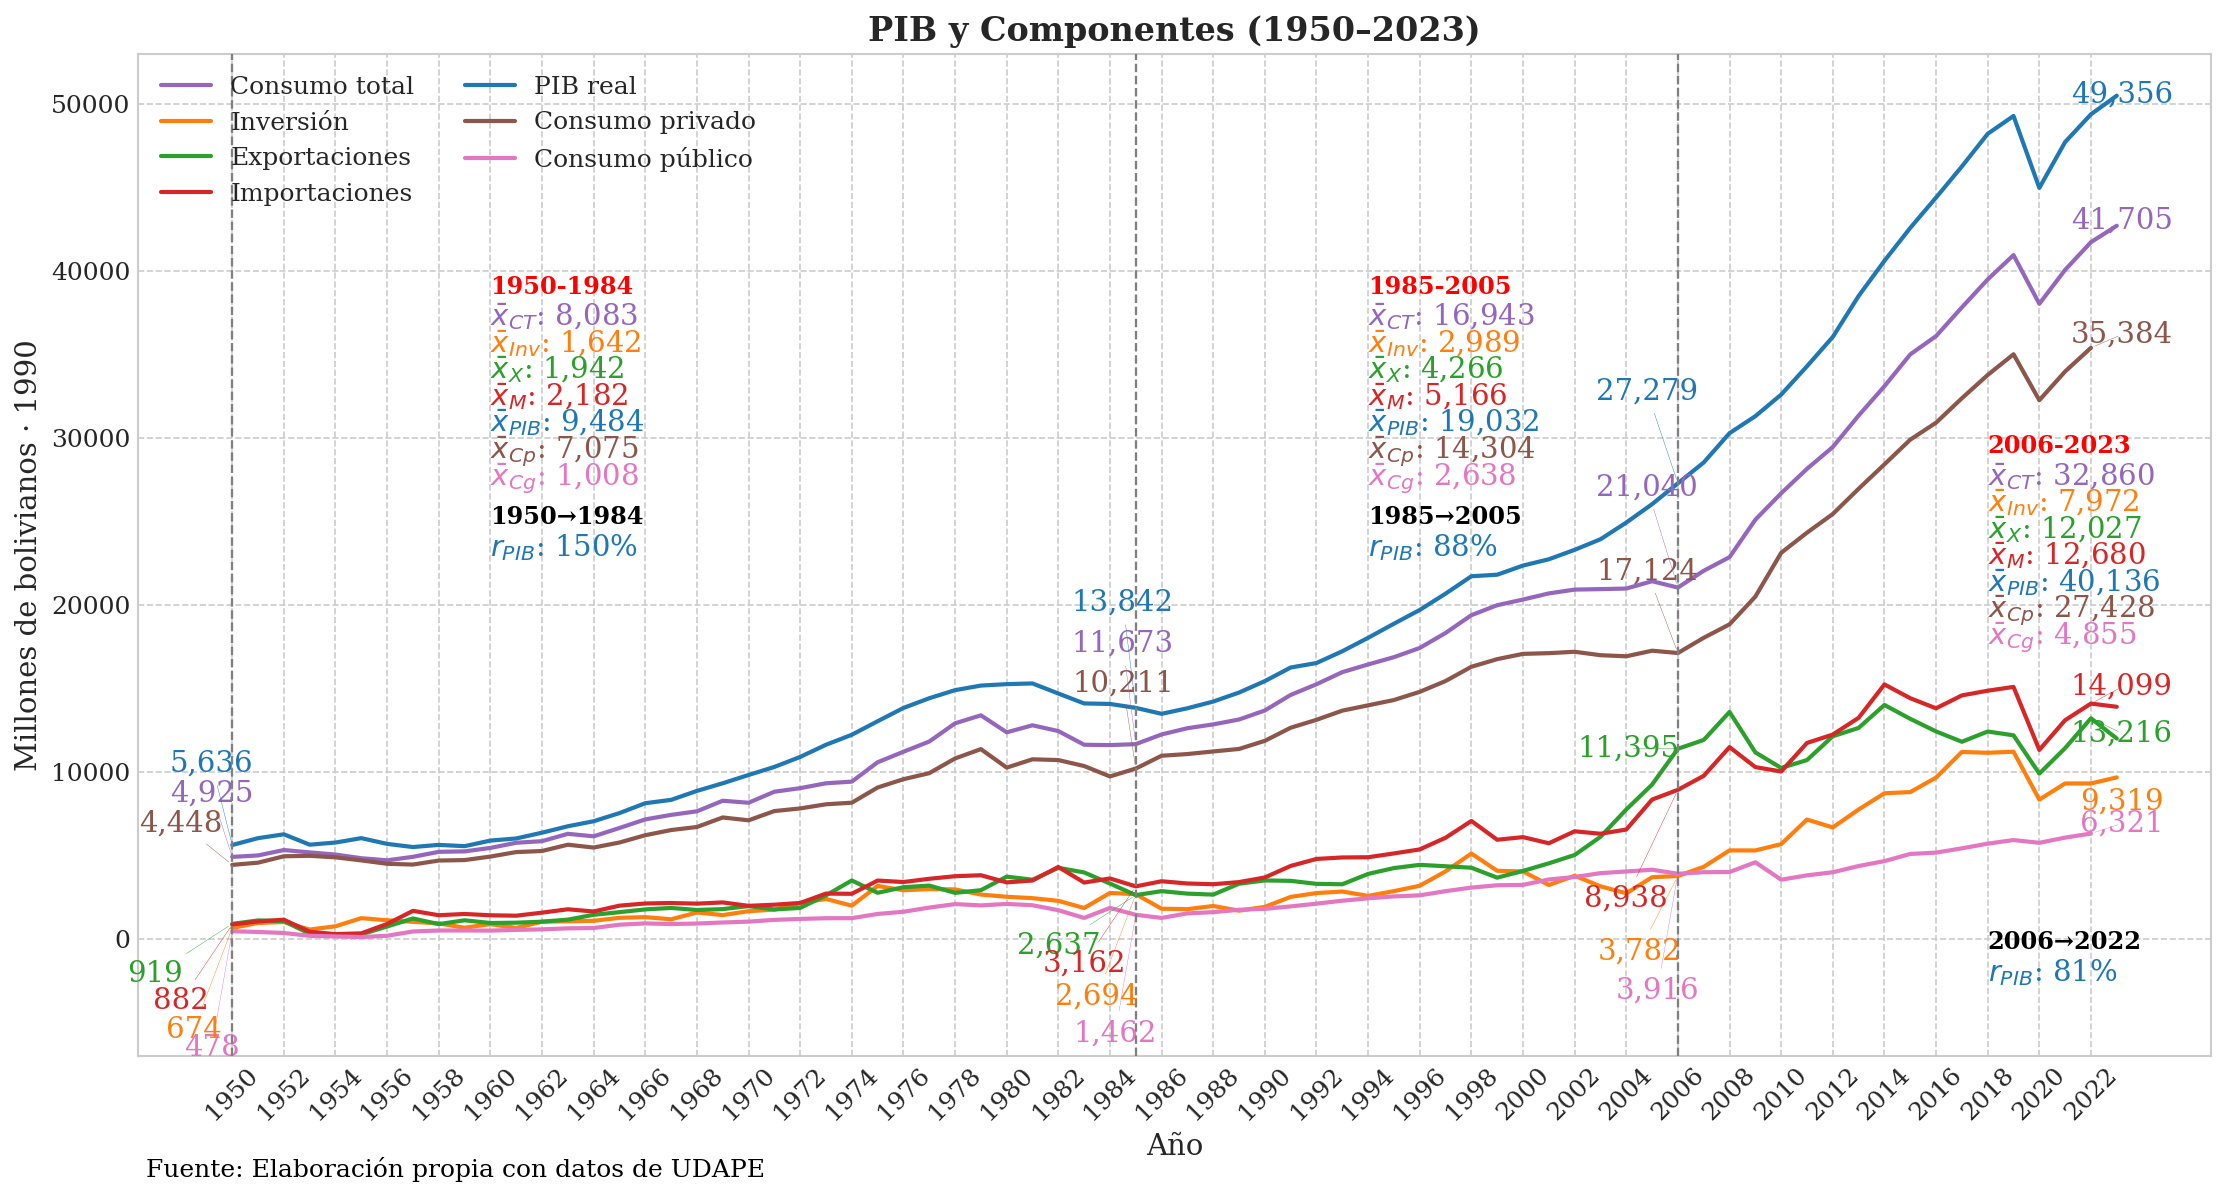

In [4]:
PERIODO_1 = slice(1950, 1984)   # Crisis
PERIODO_2 = slice(1985, 2005)   # Expansión
PERIODO_3 = slice(2006, 2023)   # Recesión

#estadisticas
avg_periodo_1   = df.loc[PERIODO_1].mean().to_dict()
avg_periodo_2    = df.loc[PERIODO_2].mean().to_dict()
avg_periodo_3   = df.loc[PERIODO_3].mean().to_dict()
# ── 4. Configuración de hitos y anotaciones ────────────────────────
# Años donde dibujaremos líneas verticales
hitos_v = {
    1950: "1950-1984",
    1985: "1985-2005",
    2006: "2006-2023",
}

# Años que queremos anotar en todas las series
anot_years = [1950,1985,2006,2022]

# ── Offsets personalizados para cada componente y año ──────────────
annotation_offsets = {
    "gastos_consumo": {
        1950: (-0.8,  3800),
        1985: (-0.5,  6000),
        2006: (-1.2,  6000),   # mismo offset que en 2005
        2022: (1.2,   1300),   # mismo offset que en 2023
    },
    "formacion_capital": {
        1950: (-1.5, -6100),
        1985: (-1.5, -6100),
        2006: (-1.5, -4500),   # mismo offset que en 2005
        2022: (1.2,  -1100),   # mismo offset que en 2023
    },
    "exportacion_bienes_servicios": {
        1950: (-3,   -3000),
        1985: (-3,   -3000),
        2006: (-1.9,     0),   # mismo offset que en 2005
        2022: (1.2,   -900),   # mismo offset que en 2023
    },
    "importacion_bienes": {
        1950: (-2,   -4600),
        1985: (-2,   -4600),
        2006: (-2,   -6500),   # mismo offset que en 2005
        2022: (1.2,   1000),   # mismo offset que en 2023
    },
    "pib_real_base_1990": {
        1950: (-0.8,  4900),
        1985: (-0.5,  6300),
        2006: (-1.2,  5500),   # mismo offset que en 2005
        2022: (1.2,   1200),   # mismo offset que en 2023
    },
    "consumo_privado": {
        1950: (-2,    2500),
        1985: (-0.5,  5100),
        2006: (-1.2,  4900),   # mismo offset que en 2005
        2022: (1.2,    800),   # mismo offset que en 2023
    },
    "consumo_publico": {
        1950: (-0.8, -7000),
        1985: (-0.8, -7100),
        2006: (-0.8, -7000),   # mismo offset que en 2005
        2022: (1.2,    600),   # mismo offset que en 2023
    },
}
hitos_offset = {
    1950: 0.45, 1985: 0.5, 2006: 0.5,
    2022: 0.70,
}
period_offsets: dict[str, tuple[float, float]] = {
    '1950-1984': (1960, 0.49),
    '1985-2005': (1994, 0.49),
    '2006-2022': (2018, 0.01),
}
text_offsets = {
    "1950-1984": (1960, 0.75),
    "1985-2005":  (1994, 0.75),
    "2006-2023": (2018, 0.57),
}
# ── 8.4 Ubicación de cuadros dentro de la gráfica ─────────────────────────

cmap = plt.get_cmap("tab10")

component_colors = {
    "gastos_consumo":               cmap(4),  # azul     → CT  
    "formacion_capital":            cmap(1),  # naranja  → Inv  
    "exportacion_bienes_servicios": cmap(2),  # verde    → X  
    "importacion_bienes":           cmap(3),  # rojo     → M  
    "pib_real_base_1990":           cmap(0),  # morado   → PIB  
    "consumo_privado":              cmap(5),  # marrón   → Cp  
    "consumo_publico":              cmap(6),  # rosa     → Cg  
}
# ── 5. Crear figura y trazar ────────────────────────────────────────
fig, ax = plt.subplots(figsize=(15,8))

for i,(col,label) in enumerate(componentes):
    ax.plot(df.index, df[col], label=label, color=component_colors[col])

# ── 6. Dibujar líneas verticales de hitos ───────────────────────────
add_hitos(ax, df.index, hitos_v, hitos_offset)
#7 anotaciones
add_year_value_annotations(
    ax,
    df,
    years=anot_years,
    columnas=[col for col, _ in componentes],
    annotation_offsets=annotation_offsets,
    colors=component_colors,
    arrow_lw=0.2
)

# Mapa de tasas por año final
periodos = [
    (1950, 1984),
    (1985, 2005),
    (2006, 2022),
]



# ── 8. Cuadros de estadísticas ───────────────────────────────────────
ybox = df.values.max() * 1.05
ax.text(df.index[0], ybox, txt_cr,
        fontsize=10, va='top', bbox=dict(facecolor='white', alpha=0.9))
ax.text(df.index[-1] - (df.index[-1]-df.index[0])*0.3, ybox, txt_po,
        fontsize=10, va='top', bbox=dict(facecolor='white', alpha=0.9))
# ── 8.1 Diccionario de abreviaturas ─────────────────────────────────────
abbr = {
    "gastos_consumo":               "CT",
    "formacion_capital":            "Inv",
    "exportacion_bienes_servicios": "X",
    "importacion_bienes":           "M",
    "pib_real_base_1990":           "PIB",
    "consumo_privado":              "Cp",
    "consumo_publico":              "Cg",
}

add_period_growth_annotations_multi(
    ax, df, periodos,
    cols=['pib_real_base_1990'],
    period_offsets=period_offsets,
    colors=component_colors,
    abbr_map={'pib_real_base_1990': 'PIB'},
)
# ── 8.2 Estadísticas (promedios enteros) por ciclo ya calculado ─────────
cycle_stats = {
    "1950-1984":   avg_periodo_1,
    "1985-2005":   avg_periodo_2,
    "2006-2023":   avg_periodo_3,
}

# ── 8.4 Ubicar y colorear estadísticas dentro de la gráfica ────────────
y_max = ax.get_ylim()[1]
# distancia vertical entre líneas de texto (en unidades de datos)
line_spacing = y_max * 0.030


add_cycle_means_multi(
    ax,
    cycle_stats,
    text_offsets,
    abbr_map=abbr,
    colors=component_colors,
    line_spacing=line_spacing
)
# ── 9. Formato final ────────────────────────────────────────────────
ax.set_title(f"PIB y Componentes ({df.index[0]}–{df.index[-1]})", fontweight='bold')
ax.set_xlabel("Año")
ax.set_ylabel("Millones de bolivianos · 1990")
ax.set_xticks(df.index[::max(1,len(df)//31)])
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='upper left', ncol=2)
ax.set_ylim(-7000, df.max().max() * 1.05)

fig.text(
    0.07, 0.005,
    "Fuente: Elaboración propia con datos de UDAPE",
    ha="left", va="bottom",
    fontsize=12, color="black",
    transform=fig.transFigure
)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "pib_componentes_2.png"))
plt.show()

